In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from pathlib import Path
import re
from typing import List, Tuple, Optional

In [7]:
import re

In [8]:
try:
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans
    SKLEARN_OK = True
except Exception:
    SKLEARN_OK = False

pd.set_option("display.max_columns", 300)
pd.set_option("display.width", 160)

In [9]:
URLS = [
    "https://uk.wikipedia.org/wiki/%D0%9D%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%BD%D1%8F_%D0%A3%D0%BA%D1%80%D0%B0%D1%97%D0%BD%D0%B8",
    "https://uk.m.wikipedia.org/wiki/%D0%9D%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%BD%D1%8F_%D0%A3%D0%BA%D1%80%D0%B0%D1%97%D0%BD%D0%B8",
]
HEADERS_LIST = [
    {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0 Safari/537.36"},
    {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 13_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.2 Safari/605.1.15"},
]
LOCAL_HTML = Path("uk_wiki_population.html")

def fetch_html_with_headers(urls: List[str], headers_list: List[dict], timeout: int = 25) -> Tuple[Optional[str], Optional[str]]:
    for url in urls:
        for headers in headers_list:
            try:
                r = requests.get(url, headers=headers, timeout=timeout, allow_redirects=True)
                if r.status_code == 200 and r.text:
                    return r.text, url
            except requests.RequestException:
                pass
    return None, None

html, used_url = fetch_html_with_headers(URLS, HEADERS_LIST)
if html is None and LOCAL_HTML.exists():
    html = LOCAL_HTML.read_text(encoding="utf-8")
    used_url = f"local://{LOCAL_HTML.name}"
if html is None:
    raise RuntimeError("Failed to fetch Wikipedia HTML (403/blocked). Try Colab or save page locally to 'uk_wiki_population.html'.")

In [10]:
all_tables = pd.read_html(html, flavor="lxml")
if not all_tables:
    raise RuntimeError(f"No tables parsed from {used_url}.")

def count_year_columns(df: pd.DataFrame, y_min: int = 1950, y_max: int = 2050) -> int:
    cnt = 0
    for c in df.columns:
        s = str(c).replace("\xa0", " ").strip()
        if re.search(r"\b(19[5-9]\d|20[0-4]\d)\b", s):
            y = int(re.search(r"(19[5-9]\d|20[0-4]\d)", s).group(1))
            if y_min <= y <= y_max:
                cnt += 1
    return cnt

scores = [(i, count_year_columns(t)) for i, t in enumerate(all_tables)]
best_idx, best_score = max(scores, key=lambda x: x[1])
df_raw = all_tables[best_idx].copy()

print(f"Fetched from: {used_url}")
print(f"Selected table index: {best_idx} (year-like cols detected: {best_score})")
print("RAW shape:", df_raw.shape)
display(df_raw.head(8))

/tmp/ipython-input-2067801754.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  all_tables = pd.read_html(html, flavor="lxml")


Fetched from: https://uk.wikipedia.org/wiki/%D0%9D%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%BD%D1%8F_%D0%A3%D0%BA%D1%80%D0%B0%D1%97%D0%BD%D0%B8
Selected table index: 29 (year-like cols detected: 17)
RAW shape: (1, 17)


,1960,1965,1970,1975,1980,1985,1990,1992,1995,1997,2000,2003,2006,2009,2010[m],2011[m],2012[m]
0,12,17,29,34,36,36,37,43,38,37,40,37,38,32,27,40,37


In [11]:
def flatten_columns(cols) -> List[str]:
    out = []
    for c in cols:
        if isinstance(c, tuple):
            s = "_".join([str(x) for x in c if x is not None])
        else:
            s = str(c)
        s = s.replace("\xa0", " ").strip()
        s = re.sub(r"\s+", " ", s)
        out.append(s)
    return out

def extract_year_token(name: str, y_min: int = 1950, y_max: int = 2050) -> Optional[str]:
    # Accept headers like "2014", "2014 [a]", "2014†", etc.
    for m in re.finditer(r"(19[5-9]\d|20[0-4]\d)", name):
        y = int(m.group(1))
        if y_min <= y <= y_max:
            return str(y)
    return None

# Replace dash placeholders early
df = df_raw.replace({"—": np.nan, "–": np.nan, "-": np.nan})

# Flatten and normalize column names
df.columns = flatten_columns(df.columns)

# Make sure the first column is region-like
first = df.columns[0]
if first.lower().startswith(("регіон", "область")) or first.lower() in ("region", "регион"):
    df = df.rename(columns={first: "Region"})
else:
    df = df.rename(columns={first: "Region"})

# Rename year-bearing headers to clean "YYYY"
rename_map = {}
for c in df.columns:
    if c == "Region":
        continue
    ytok = extract_year_token(c)
    if ytok:
        rename_map[c] = ytok
df = df.rename(columns=rename_map)

# Resolve duplicate year names by averaging row-wise
if df.columns.duplicated().any():
    grouped = {}
    for col in df.columns.unique():
        sub = df.loc[:, df.columns == col]
        if sub.shape[1] == 1:
            grouped[col] = sub.iloc[:, 0]
        else:
            grouped[col] = sub.mean(axis=1, numeric_only=True)
    df = pd.DataFrame(grouped)

# Convert non-Region columns to numeric
numeric_cols = [c for c in df.columns if c != "Region"]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

print("\nNORMALIZED columns (first 25):", list(df.columns)[:25])
print("COLUMNS count:", len(df.columns))
display(df.head(5))


NORMALIZED columns (first 25): ['Region', '1965', '1970', '1975', '1980', '1985', '1990', '1992', '1995', '1997', '2000', '2003', '2006', '2009', '2010', '2011', '2012']
COLUMNS count: 17


,Region,1965,1970,1975,1980,1985,1990,1992,1995,1997,2000,2003,2006,2009,2010,2011,2012
0,12,17,29,34,36,36,37,43,38,37,40,37,38,32,27,40,37


In [12]:
print("\nHEAD():")
display(df.head())


HEAD():


,Region,1965,1970,1975,1980,1985,1990,1992,1995,1997,2000,2003,2006,2009,2010,2011,2012
0,12,17,29,34,36,36,37,43,38,37,40,37,38,32,27,40,37


In [13]:
print("SHAPE:", df.shape)

SHAPE: (1, 17)


In [14]:
print("\nDTYPES:")
print(df.dtypes)


DTYPES:
Region    int64
1965      int64
1970      int64
1975      int64
1980      int64
1985      int64
1990      int64
1992      int64
1995      int64
1997      int64
2000      int64
2003      int64
2006      int64
2009      int64
2010      int64
2011      int64
2012      int64
dtype: object


In [15]:
missing_fraction = df.isna().mean()
print("\nMISSING FRACTION PER COLUMN:")
display(missing_fraction.to_frame("missing_fraction"))


MISSING FRACTION PER COLUMN:


,missing_fraction
Region,0.0
1965,0.0
1970,0.0
1975,0.0
1980,0.0
1985,0.0
1990,0.0
1992,0.0
1995,0.0
1997,0.0


In [16]:
df_no_country = df.iloc[:-1].copy() if len(df) > 0 else df.copy()

# Fill NaNs in numeric columns with column mean
means = df_no_country[[c for c in df_no_country.columns if c != "Region"]].mean(numeric_only=True)
df_filled = df_no_country.copy()
for c in df_filled.columns:
    if c == "Region":
        continue
    df_filled[c] = pd.to_numeric(df_filled[c], errors="coerce")
df_filled.loc[:, df_filled.columns != "Region"] = df_filled.loc[:, df_filled.columns != "Region"].fillna(means)

print("\nAfter drop country + fillna preview:")
display(df_filled.head())


After drop country + fillna preview:


,Region,1965,1970,1975,1980,1985,1990,1992,1995,1997,2000,2003,2006,2009,2010,2011,2012


In [17]:
def detect_year_columns(columns, y_min=1900, y_max=2100) -> List[int]:
    ys = []
    for c in columns:
        s = str(c).strip()
        if re.fullmatch(r"\d{4}", s):
            y = int(s)
            if y_min <= y <= y_max:
                ys.append(y)
    return sorted(set(ys))

years = detect_year_columns(df_filled.columns, 1900, 2100)
if not years:
    raise RuntimeError("No year-like numeric columns detected after normalization.")

def nearest_year(target: int, available: List[int]) -> int:
    arr = np.array(available)
    return int(arr[np.argmin(np.abs(arr - target))])

target_2019 = nearest_year(2019, years)
target_2014 = nearest_year(2014, years)

print(f"\nAvailable years: {years[:10]} ... {years[-10:] if len(years)>10 else years}")
print(f"Chosen for '2019' task {target_2019} (nearest available)")
print(f"Chosen for '2014' task {target_2014} (nearest available)")

col_2019 = str(target_2019)
col_2014 = str(target_2014)


Available years: [1965, 1970, 1975, 1980, 1985, 1990, 1992, 1995, 1997, 2000] ... [1992, 1995, 1997, 2000, 2003, 2006, 2009, 2010, 2011, 2012]
Chosen for '2019' task 2012 (nearest available)
Chosen for '2014' task 2012 (nearest available)


In [18]:
mean_2019 = df_filled[col_2019].mean()
above_2019 = (df_filled.loc[df_filled[col_2019] > mean_2019, ["Region", col_2019]]
              .sort_values(by=col_2019, ascending=False)
              .reset_index(drop=True))
print(f"\nMean {col_2019}: {mean_2019:.3f}")
print(f"Regions with {col_2019} > mean:")
display(above_2019)


Mean 2012: nan
Regions with 2012 > mean:


,Region,2012


In [19]:
year_cols_all = [c for c in df_filled.columns if c != "Region" and re.fullmatch(r"\d{4}", str(c))]
years_available = sorted(map(int, year_cols_all))
if not years_available:
    raise RuntimeError("No numeric year columns (YYYY) found in df_filled after normalization.")

In [20]:
non_null_counts = {y: int(df_filled[str(y)].notna().sum()) for y in years_available}
non_null_df = pd.DataFrame({"Year": years_available, "non_null": [non_null_counts[y] for y in years_available]})
non_null_df["coverage"] = non_null_df["non_null"] / len(df_filled)
non_null_df = non_null_df.sort_values("Year").reset_index(drop=True)

In [21]:
print("\nNon-null coverage per year (top 15 rows):")
display(non_null_df.head(15))


Non-null coverage per year (top 15 rows):


,Year,non_null,coverage
0,1965,0,NaN
1,1970,0,NaN
2,1975,0,NaN
3,1980,0,NaN
4,1985,0,NaN
5,1990,0,NaN
6,1992,0,NaN
7,1995,0,NaN
8,1997,0,NaN
9,2000,0,NaN


In [23]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [24]:
plt.rcParams["font.family"] = "DejaVu Sans"

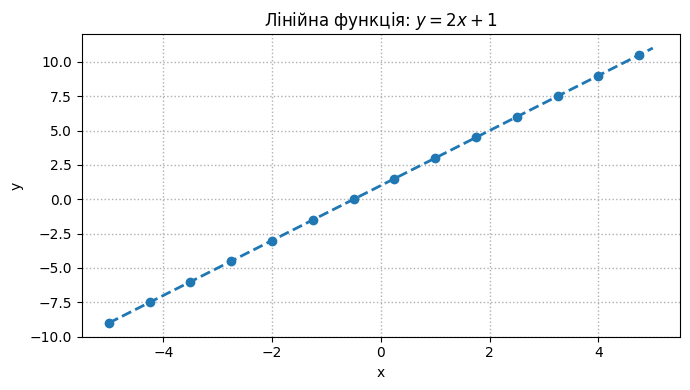

In [25]:
x = np.linspace(-5, 5, 201)
y = 2*x + 1

plt.figure(figsize=(7, 4))
plt.plot(x, y, linestyle="--", linewidth=2.0, marker="o", markevery=15)
plt.title("Лінійна функція: $y=2x+1$")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True, linestyle=":", linewidth=1)
plt.tight_layout()
plt.show()

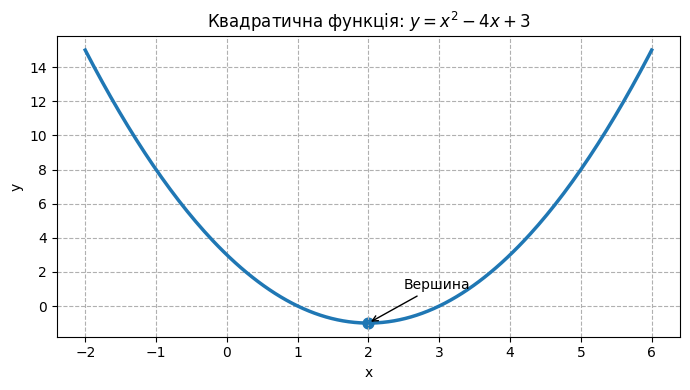

In [26]:
x = np.linspace(-2, 6, 201)
y = x**2 - 4*x + 3

# Вершина параболи: x_v = -b/(2a) = 4/2 = 2; y_v = f(2)
x_v = 2
y_v = x_v**2 - 4*x_v + 3

plt.figure(figsize=(7, 4))
plt.plot(x, y, linewidth=2.5)
plt.scatter([x_v], [y_v], s=60)
plt.title("Квадратична функція: $y=x^2-4x+3$")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True, linestyle="--", linewidth=0.8)
plt.annotate("Вершина", xy=(x_v, y_v), xytext=(x_v+0.5, y_v+2),
             arrowprops=dict(arrowstyle="->", linewidth=1))
plt.tight_layout()
plt.show()

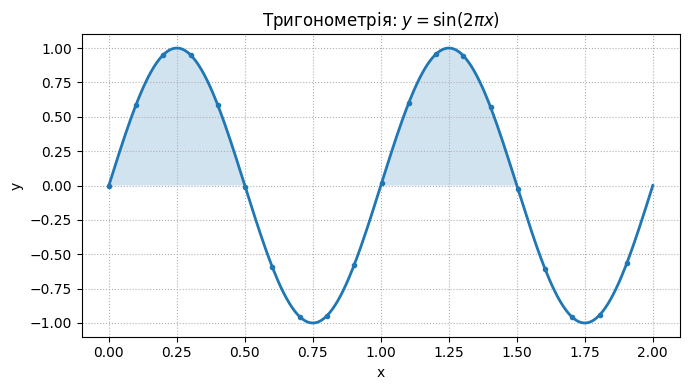

In [27]:
x = np.linspace(0, 2, 400)
y = np.sin(2*np.pi*x)

plt.figure(figsize=(7, 4))
plt.plot(x, y, linewidth=2, marker=".", markevery=20)
# Заповнюємо область, де y >= 0
plt.fill_between(x, 0, y, where=(y >= 0), alpha=0.2)
plt.title(r"Тригонометрія: $y=\sin(2\pi x)$")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True, linestyle=":", linewidth=0.8)
plt.tight_layout()
plt.show()

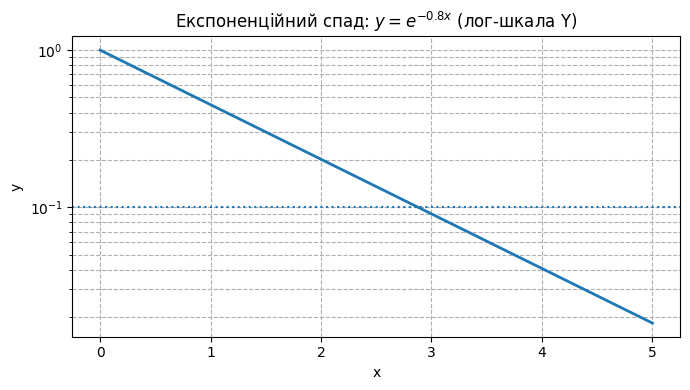

In [28]:
x = np.linspace(0, 5, 300)
y = np.exp(-0.8*x)

plt.figure(figsize=(7, 4))
plt.semilogy(x, y, linewidth=2)
plt.title(r"Експоненційний спад: $y=e^{-0.8x}$ (лог-шкала Y)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True, which="both", linestyle="--", linewidth=0.8)
plt.axhline(0.1, linestyle=":", linewidth=1.5)   # поріг 0.1
plt.tight_layout()
plt.show()

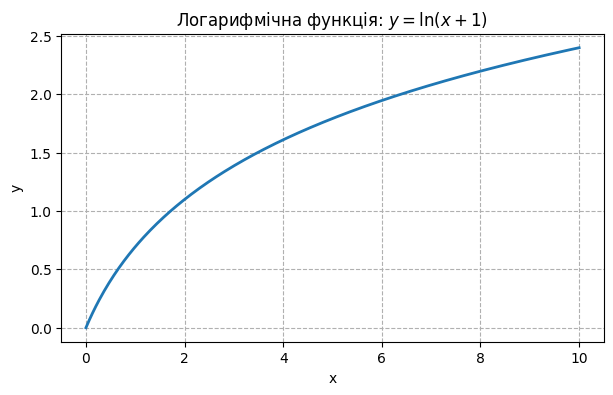

In [29]:
x = np.linspace(0, 10, 300)
y = np.log(x + 1)

plt.figure(figsize=(7, 4))
plt.plot(x, y, linewidth=2)
plt.title(r"Логарифмічна функція: $y=\ln(x+1)$")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True, linestyle="--", linewidth=0.8)

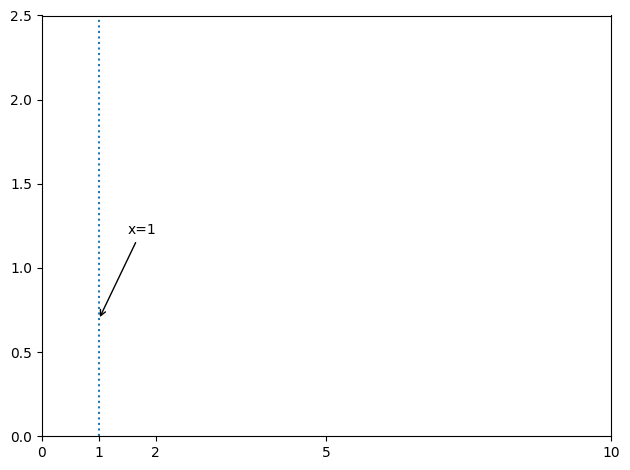

In [30]:
plt.xticks([0, 1, 2, 5, 10])
plt.yticks([0, 0.5, 1, 1.5, 2, 2.5])

# Вертикальна лінія і підпис
plt.axvline(1, linestyle=":", linewidth=1.5)
plt.annotate("x=1", xy=(1, np.log(2)), xytext=(1.5, 1.2),
             arrowprops=dict(arrowstyle="->", linewidth=1))
plt.tight_layout()
plt.show()